# Statistics summary
This notebook is a brief introduction to various statistical analyses commonly used for amplicon data analysis - including some basic theory, links to more in-depth explanations, how to run them in R, and how to ensure the assumptions hold.

### Getting more in-depth
Excellent introductions to various statistical concepts and analysis can be found in a [Nature Methods collection of 2-page letters aimed at biologists](https://www.nature.com/collections/qghhqm/pointsofsignificance).

The first paper, [Importance of being uncertain](http://www.nature.com/doifinder/10.1038/nmeth.2613), is a must read for anyone new to statistics.

The [GUSTA ME website](https://mb3is.megx.net/gustame) contains descriptions of many multivariate analyses aimed at microbial ecologists using R.


# Contents
* [Two sample T-test](#t-test)
* [Wilcoxon Rank Sum test](#wilcoxon)
* [Paired two-sample tests](#paired)
* [Correlation](#correlation)
* [Linear regression](#regression)
* [ANOVA](#anova)
* [Linear model](#linear_model)
* [Mixed-effect linear model](#mixed)
* [Interactions](#interactions)
* [Ordinations](#ordination)
* [PCA](#pca)
* [PCoA](#pcoa)
* [PERMANOVA](#permanova)
* [Corrections for multiple comparisons](#multiple)


In [30]:
# Load packages
library(ggplot2) # Plotting

# Example datasets
**mtcars:** The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles

In [21]:
data(mtcars)

# Two sample T-test <a class="anchor" id="t-test"></a>
The two-sample t-test is used for comparing the means of two samples; for example comparing a control condition with a treatment.

### Assumptions
1. Samples are uncorrelated. This is the most crucial assumption: Samples should be independent. If the samples are paired, for example with before and after measurements, or in other ways correlated one-to-one, use the paired t-test.

2. Samples come from a population that have an approximately normal shape. It is quite robust to deviations, but will have higher chance of false positives/negatives with highly non-normal distributions. Transformations (e.g. log transform) can sometimes solve this problem.

3. Variance is equal in the two samples. The t-test is however very robust to deviations from this assumption. In R the default t-test is the Welch variant, which solves the problem of unequal variances from unequal sample sizes.

### In R
Let's compare the engine displacement of cars with automatic transmission (am = 1) compared to manual transmission (am = 0)

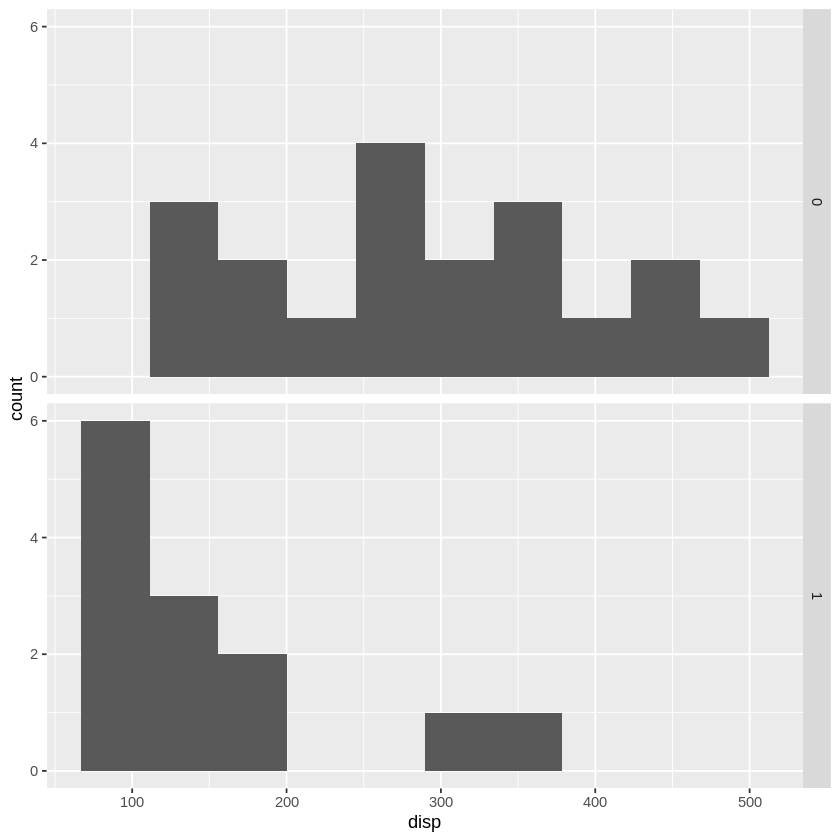

In [31]:
ggplot(mtcars, aes(disp)) + facet_grid(am ~ .) + geom_histogram(bins = 10)

In [23]:
t.test(disp ~ am, data = mtcars) 


	Welch Two Sample t-test

data:  disp by am
t = 4.1977, df = 29.258, p-value = 0.00023
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  75.32779 218.36857
sample estimates:
mean in group 0 mean in group 1 
       290.3789        143.5308 


We can see that the average displacement in cars with manual transmission (group 0) is 290, and in cars with automatic transmission (group 1) is 144. This difference is significant with a p-value of 0.00023. The difference between the two is between 75 and 218 (95% confidence interval)

# Wilcoxon Rank Sum test <a class="anchor" id="wilcoxon"></a>
The Wilcoxon Rank Sum test is used to compare the medians of two samples, similar to a two sample t-test. This test is however non-parametric and therefore has (almost) no assumptions on the distributions of the populations. It is less powerful than the t-test, especially for small (n<10) sample sizes.

### Assumptions
1. Similar to the t-test, the samples should be uncorrelated and independent. A paired version of this test is the Wilcoxon Signed Rank test.

2. The two samples should be drawn from populations with approximately similar shape. 

### In R:
Let's compare the engine displacement of cars with automatic transmission (am = 1) compared to manual transmission (am = 0)

In [32]:
wilcox.test(disp ~ am, data = mtcars) 

Warning message in wilcox.test.default(x = c(258, 360, 225, 360, 146.7, 140.8, 167.6, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  disp by am
W = 214, p-value = 0.0005493
alternative hypothesis: true location shift is not equal to 0


We can see that the average displacement in cars with manual transmission (group 0) is different than in cars with automatic transmission (group 1) a p-value of 0.0005493. The warnings tells us that some displacement values are similar, which means the p-value is an approximation. This is not problematic unless there are many ties.

# Paired two sample tests <a class="anchor" id="paired"></a>
If samples are paired, a paired test should be used. This should be used to for example before and after measurements on the same subjects. See the above two sections for assumptions.

In R it is crucial that the observations are in correct order, as the samples are paired according to the input order.

### Ordering data in R
First we make an example dataset

In [6]:
# Set seed (for reproducibility when doing things that involves randomness)
set.seed(42)
# Set number of samples
nSamples <- 10
# Build data.frame with random measurements
pairedData <- data.frame(sampletime = c(rep("before", nSamples), rep("after", nSamples)),
                        subject = rep(LETTERS[1:nSamples], 2),
                         measurement = rnorm(nSamples * 2))
# Shuffle data.frame
pairedData <- pairedData[sample(1:nrow(pairedData)), ]

If we look at the dataset, we can see that it is unordered:

In [7]:
pairedData

,sampletime,subject,measurement
11,after,A,1.30486965
15,after,E,-0.13332134
8,before,H,-0.09465904
4,before,D,0.63286260
17,after,G,-0.28425292
6,before,F,-0.10612452
2,before,B,-0.56469817
13,after,C,-1.38886070
12,after,B,2.28664539
5,before,E,0.40426832


Let's order it by subject:

In [8]:
pairedDataOrder <- pairedData[order(pairedData$subject), ]
pairedDataOrder

,sampletime,subject,measurement
11,after,A,1.30486965
1,before,A,1.37095845
2,before,B,-0.56469817
12,after,B,2.28664539
13,after,C,-1.38886070
3,before,C,0.36312841
4,before,D,0.63286260
14,after,D,-0.27878877
15,after,E,-0.13332134
5,before,E,0.40426832


### Paired t-test in R

In [12]:
before <- pairedDataOrder[pairedDataOrder$sampletime == "before", "measurement"]
after <- pairedDataOrder[pairedDataOrder$sampletime == "after", "measurement"]

t.test(after, before, paired = TRUE)


	Paired t-test

data:  after and before
t = -1.0742, df = 9, p-value = 0.3107
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.2075921  0.7860851
sample estimates:
mean of the differences 
             -0.7107535 


The average difference between before and after measurements is -0.71 (-2.21 to 0.79, 95% CI) and this is not statistically significant, p-value = 0.3107. 

Also notice that we only have 9 degrees of freedom, despite having 20 observations in the input data.frame. This is because we have repeated measurements within subjects, and we actually only have 10 independent measurements. A paired t-test is therefore equivalent to finding the difference between before and after measuremnts and then running a one-sample t-test:

In [13]:
# Find the difference
difference <- after - before
difference

[1] -0.06608879  2.85134356 -1.75198911 -0.91165137 -0.53758966  0.74207491
 [7] -1.79577492 -2.56179638 -4.45889064  1.38282744

In [14]:
# One-sample t-test
t.test(difference, mu = 0)


	One Sample t-test

data:  difference
t = -1.0742, df = 9, p-value = 0.3107
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -2.2075921  0.7860851
sample estimates:
 mean of x 
-0.7107535 


This result is exactly identical to the paired two-sample test.

# Correlation <a class="anchor" id="correlation"></a>
It is advised to read [this excellent introduction to the difference between correlation, association, and causation](https://www.nature.com/articles/nmeth.3587).

As the paper states: *two variables are correlated when they display an increasing or decreasing trend*



# Linear regression <a class="anchor" id="regression"></a>

# ANOVA <a class="anchor" id="anova"></a>

# Linear model <a class="anchor" id="linear_model"></a>

# Mixed-effect linear model <a class="anchor" id="mixed"></a>

# Interactions in linear models <a class="anchor" id="interactions"></a>

# Ordination <a class="anchor" id="ordination"></a>

# PCA <a class="anchor" id="pca"></a>

# PCoA <a class="anchor" id="pcoa"></a>

# PERMANOVA <a class="anchor" id="permanova"></a>

# Corrections for multiple comparisons  <a class="anchor" id="multiple"></a>